In [1]:
# import libraries

# keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# basic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing, model selection and scores

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# nlp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
# read in the data

data = pd.read_csv('../data/cleaned/labeled.csv')

In [3]:
# select only lemmatized column and label

df = data[['lemmatized', 'label']]

In [4]:
# set up X and y

X = df['lemmatized']
y = df['label']

# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 2020)

### Preprocessing for modeling

In [5]:
# update stop_words for TF-IDF vectorizer

remove = ['-pron-', 'feel', 'know', 'want', 'life', 'go', 'think', 'make', 'people', 'really', 'even', 'much', 'now', 
          'pron', 'don', 'will', 'try', 'talk', 'friends', 'tell', 'just', 'like', 'time', 'want', 'well', 'thing', 'day',
          'friend', 'help', 'year', 'bad', 've', 'say', 'good', 'need', 'way', 'right', 'month', 'amp', 'x200b']

my_stop_words = text.ENGLISH_STOP_WORDS.union(remove)

In [6]:
# instantiate Tf-IDF

tvec = TfidfVectorizer(stop_words = my_stop_words, max_df = .80, min_df = 10, max_features = 256, ngram_range = (1, 1))

In [7]:
# fit/transform X then save it to a dataframe

train = tvec.fit_transform(X_train).toarray()
print(train.shape)

test = tvec.fit_transform(X_test).toarray()
print(test.shape)

(71425, 256)
(30612, 256)


In [8]:
train[0].shape

(256,)

In [9]:
# reshape to fit

train = train.reshape(train.shape[0], 1, train.shape[-1])
test = test.reshape(test.shape[0], 1, test.shape[-1])

In [10]:
train[0].shape

(1, 256)

## Model 1

In [11]:
# instantiate sequential model

model_1 = Sequential()

# add layers

model_1.add(Bidirectional(LSTM(32, return_sequences = False), input_shape = (1, 256)))

model_1.add(Dense(32,
                  activation = 'relu'))

model_1.add(Dense(1,
                  activation = 'sigmoid'))

# compile

model_1.compile(loss = 'bce',
                optimizer = 'adam',
                metrics = ['acc'])

# check the model summary

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                73984     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 76,097
Trainable params: 76,097
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit

batch = 256
num_epochs = 25

history_1 = model_1.fit(train, y_train,
                        batch_size = batch,
                        epochs = num_epochs, 
                        validation_data = (test, y_test))

Epoch 1/25
280/280 [==============================] - 1s 5ms/step - loss: 0.4605 - acc: 0.8049 - val_loss: 0.4983 - val_acc: 0.7920
Epoch 2/25
280/280 [==============================] - 1s 3ms/step - loss: 0.3988 - acc: 0.8235 - val_loss: 0.5042 - val_acc: 0.7921
Epoch 3/25
280/280 [==============================] - 1s 3ms/step - loss: 0.3950 - acc: 0.8244 - val_loss: 0.5028 - val_acc: 0.7905
Epoch 4/25
280/280 [==============================] - 1s 3ms/step - loss: 0.3934 - acc: 0.8245 - val_loss: 0.4993 - val_acc: 0.7907
Epoch 5/25
280/280 [==============================] - 1s 3ms/step - loss: 0.3920 - acc: 0.8253 - val_loss: 0.5040 - val_acc: 0.7889
Epoch 6/25
280/280 [==============================] - 1s 3ms/step - loss: 0.3901 - acc: 0.8271 - val_loss: 0.5042 - val_acc: 0.7889
Epoch 7/25
280/280 [==============================] - 1s 3ms/step - loss: 0.3885 - acc: 0.8276 - val_loss: 0.5039 - val_acc: 0.7876
Epoch 8/25
280/280 [==============================] - 1s 3ms/step - loss: 0.

In [13]:
# plot losses and accuracies

def plots(history, which):   
    plt.figure(figsize = (8, 6))
    plt.plot(history.history[which], label = f'Train {which.title()}')
    plt.plot(history.history['val_' + which], label = f'Test {which.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(which.title())
    plt.legend()
    plt.show()
    
    return

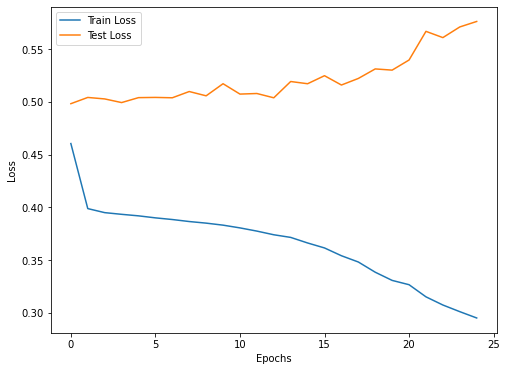

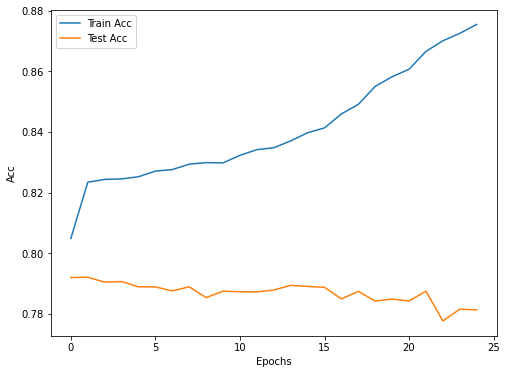

In [14]:
plots(history_1, 'loss')
plots(history_1, 'acc')

## Model 2

In [15]:
# instantiate sequential model

model_2 = Sequential()

# add layers

model_2.add(Bidirectional(LSTM(64, return_sequences = False), input_shape = (1, 256)))

model_2.add(Dense(64,
                  activation = 'relu'))

model_2.add(Dropout(0.5))

model_2.add(Dense(16,
                  activation = 'relu'))

model_2.add(Dense(1,
                  activation = 'sigmoid'))

# compile

model_2.compile(loss = 'bce',
                optimizer = 'adam',
                metrics = ['acc'])

# check the model summary

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 173,665
Trainable params: 173,665
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit

batch = 256
num_epochs = 25

history_2 = model_2.fit(train, y_train,
                        batch_size = batch,
                        epochs = num_epochs, 
                        validation_data = (test, y_test))

Epoch 1/25
280/280 [==============================] - 2s 7ms/step - loss: 0.4482 - acc: 0.8071 - val_loss: 0.4977 - val_acc: 0.7924
Epoch 2/25
280/280 [==============================] - 2s 5ms/step - loss: 0.4010 - acc: 0.8232 - val_loss: 0.5127 - val_acc: 0.7905
Epoch 3/25
280/280 [==============================] - 1s 5ms/step - loss: 0.3974 - acc: 0.8250 - val_loss: 0.5161 - val_acc: 0.7910
Epoch 4/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3949 - acc: 0.8260 - val_loss: 0.5109 - val_acc: 0.7894
Epoch 5/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3938 - acc: 0.8269 - val_loss: 0.5117 - val_acc: 0.7872
Epoch 6/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3912 - acc: 0.8277 - val_loss: 0.5000 - val_acc: 0.7892
Epoch 7/25
280/280 [==============================] - 1s 5ms/step - loss: 0.3895 - acc: 0.8295 - val_loss: 0.5084 - val_acc: 0.7866
Epoch 8/25
280/280 [==============================] - 1s 5ms/step - loss: 0.

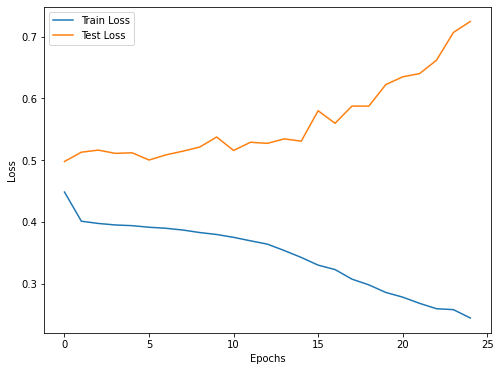

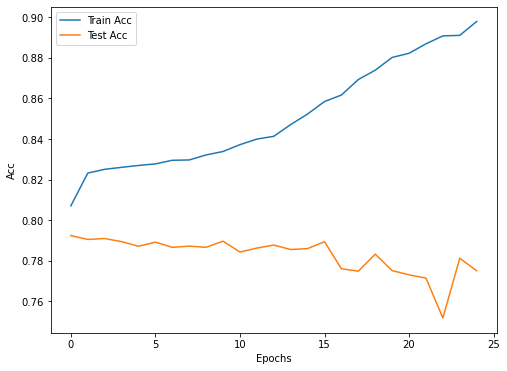

In [17]:
# plot losses and accuracies

plots(history_2, 'loss')
plots(history_2, 'acc')

## Model 3

In [18]:
# instantiate sequential model

model_3 = Sequential()

# add layers

model_3.add(Bidirectional(LSTM(64, return_sequences = False), input_shape = (1, 256)))

model_3.add(Dense(32,
                  activation = 'relu'))

model_3.add(Dropout(0.5))

model_3.add(Dense(16,
                  activation = 'relu'))

model_3.add(Dense(1,
                  activation = 'sigmoid'))

# compile

model_3.compile(loss = 'bce',
                optimizer = 'adam',
                metrics = ['acc'])

# check the model summary

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 169,025
Trainable params: 169,025
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit

batch = 256
num_epochs = 25

history_3 = model_3.fit(train, y_train,
                        batch_size = batch,
                        epochs = num_epochs, 
                        validation_data = (test, y_test))

Epoch 1/25
280/280 [==============================] - 2s 7ms/step - loss: 0.4583 - acc: 0.8009 - val_loss: 0.5060 - val_acc: 0.7886
Epoch 2/25
280/280 [==============================] - 1s 5ms/step - loss: 0.4028 - acc: 0.8219 - val_loss: 0.4991 - val_acc: 0.7901
Epoch 3/25
280/280 [==============================] - 1s 5ms/step - loss: 0.3986 - acc: 0.8251 - val_loss: 0.5052 - val_acc: 0.7905
Epoch 4/25
280/280 [==============================] - 1s 5ms/step - loss: 0.3960 - acc: 0.8256 - val_loss: 0.4992 - val_acc: 0.7817
Epoch 5/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3939 - acc: 0.8264 - val_loss: 0.5009 - val_acc: 0.7846
Epoch 6/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3921 - acc: 0.8274 - val_loss: 0.5040 - val_acc: 0.7863
Epoch 7/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3901 - acc: 0.8282 - val_loss: 0.5121 - val_acc: 0.7859
Epoch 8/25
280/280 [==============================] - 2s 6ms/step - loss: 0.

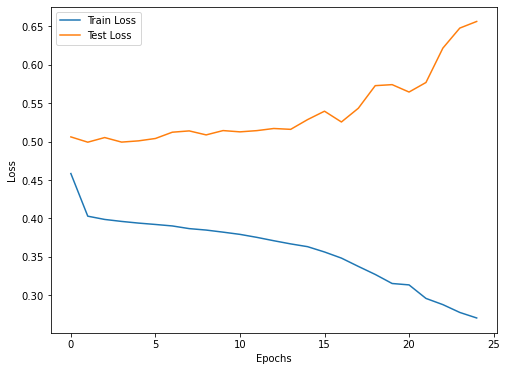

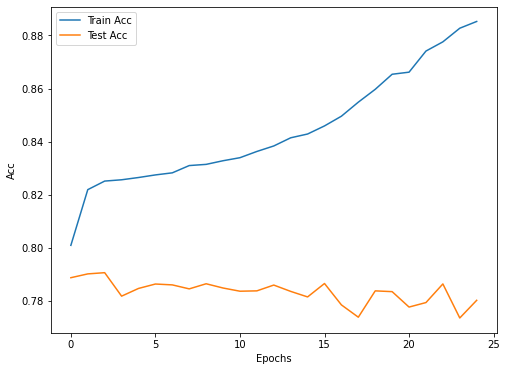

In [21]:
# plot losses and accuracies

plots(history_3, 'loss')
plots(history_3, 'acc')

## Model 4

In [22]:
# instantiate sequential model

model_4 = Sequential()

# add layers

model_4.add(Bidirectional(LSTM(64, return_sequences = False), input_shape = (1, 256)))

model_4.add(Dropout(0.25))

model_4.add(Dense(32,
                  activation = 'relu'))

model_4.add(Dropout(0.25))

model_4.add(Dense(16,
                  activation = 'relu'))

model_4.add(Dense(1,
                  activation = 'sigmoid'))

# compile

model_4.compile(loss = 'bce',
                optimizer = 'adam',
                metrics = ['acc'])

# check the model summary

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 169,025
Trainable params: 169,025
Non-trainable params: 0
________________________________________________

In [23]:
# fit

batch = 256
num_epochs = 25

history_4 = model_4.fit(train, y_train,
                        batch_size = batch,
                        epochs = num_epochs, 
                        validation_data = (test, y_test))

Epoch 1/25
280/280 [==============================] - 2s 8ms/step - loss: 0.4481 - acc: 0.8076 - val_loss: 0.4930 - val_acc: 0.7896
Epoch 2/25
280/280 [==============================] - 2s 5ms/step - loss: 0.4008 - acc: 0.8230 - val_loss: 0.5098 - val_acc: 0.7919
Epoch 3/25
280/280 [==============================] - 2s 5ms/step - loss: 0.3966 - acc: 0.8247 - val_loss: 0.5062 - val_acc: 0.7899
Epoch 4/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3942 - acc: 0.8267 - val_loss: 0.5058 - val_acc: 0.7925
Epoch 5/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3920 - acc: 0.8267 - val_loss: 0.5102 - val_acc: 0.7849
Epoch 6/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3905 - acc: 0.8279 - val_loss: 0.5028 - val_acc: 0.7872
Epoch 7/25
280/280 [==============================] - 2s 6ms/step - loss: 0.3882 - acc: 0.8283 - val_loss: 0.5061 - val_acc: 0.7868
Epoch 8/25
280/280 [==============================] - 2s 6ms/step - loss: 0.

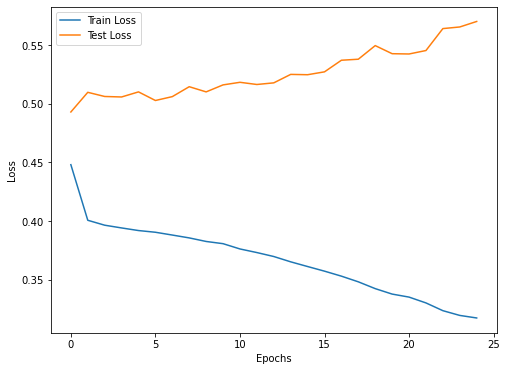

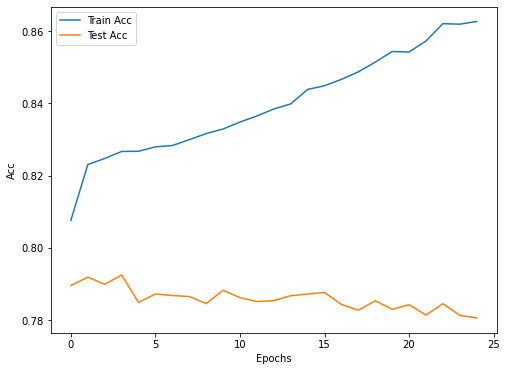

In [24]:
# plot losses and accuracies

plots(history_4, 'loss')
plots(history_4, 'acc')

## Hyperparameter tuning

In [27]:
# create a function skeleton for tuning

def model_func(lstm_unit = 128, layer_one_neurons = 32, layer_two_neurons = 32, layer_one_dropout = 0.5, layer_two_dropout = 0.5):
    
    # instantiate the model
    model = Sequential()
    
    # add layers
    model.add(Bidirectional(LSTM(units = lstm_unit, return_sequences = False), input_shape = (1, 256)))
    model.add(Dense(units = layer_one_neurons, activation = 'relu'))
    model.add(Dropout(layer_one_dropout))
    model.add(Dense(units = layer_two_neurons, activation ='relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # compile
    model.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

# build the model

nn = KerasClassifier(build_fn = model_func, epochs = 10, batch_size = 512, verbose = 0)

In [ ]:
# params grid

params = {
    'epochs':[10, 20],
    'batch_size': [128, 256, 512, 1024],
    'lstm_unit': [4, 16, 32, 128],
    'layer_one_neurons': [16, 32],
    'layer_two_neurons': [16, 32],
    'layer_one_dropout': [0.1, 0.2, 0.5]
}

# instantiate gridsearch

gs = GridSearchCV(estimator = nn, param_grid = params, cv = 3)

# fit

gs.fit(train, y_train)

print(f'Best score: {gs.best_score_}')
print(f'Best parameters: {gs.best_params_}')